In [ ]:
import os
import json
from types import SimpleNamespace
from collections import Counter

import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset

import MT_baselines as mt

try:
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("[WARN] sklearn not installed, PCA/KMeans will be skipped.")

plt.style.use("ggplot")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

OUTDIR = "runs_mt_3"


RUNS = {
    "GRU_char": "gru_char_seed42_ls0",
    "GRU_sentencepiece": "gru_sp_seed42_ls0",
    "GRU_whitespace": "gru_ws_seed42_ls0",
    "lstm_char": "lstm_char_seed42_ls0",
    "lstm_sentencepiece": "lstm_sp_seed42_ls0",
    "lstm_whitespace": "lstm_ws_seed42_ls0"
}


COLOR_CYCLE = [
    "tab:orange",
    "tab:blue",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]


Using device: cuda


In [ ]:
def load_run(run_name):
    exp_dir = os.path.join(OUTDIR, run_name)
    assert os.path.isdir(exp_dir), f"Experiment dir not found: {exp_dir}"

    args_path = os.path.join(exp_dir, "args.json")
    with open(args_path, "r", encoding="utf-8") as f:
        args_dict = json.load(f)
    args = SimpleNamespace(**args_dict)

    ckpt_path = os.path.join(exp_dir, f"{args.model}_best.pt")
    if not os.path.exists(ckpt_path):
        candidates = [fn for fn in os.listdir(exp_dir) if fn.endswith("_best.pt")]
        if not candidates:
            raise FileNotFoundError(f"No *_best.pt found in {exp_dir}")
        ckpt_path = os.path.join(exp_dir, candidates[0])

    print(f"[{run_name}] Loading checkpoint:", ckpt_path)
    ckpt = torch.load(ckpt_path, map_location="cpu")

    src_vocab = ckpt["src_vocab"]
    tgt_vocab = ckpt["tgt_vocab"]

    src_vocab, tgt_vocab, src_pad_idx, tgt_pad_idx, train_loader, val_loader = mt.build_data(
        args, src_vocab=src_vocab, tgt_vocab=tgt_vocab
    )

    model, optimizer, criterion, decode_greedy, decode_beam, model_name, model_config = mt.build_model(
        args, src_vocab, tgt_vocab, src_pad_idx, tgt_pad_idx
    )

    mt.load_model_state(model, ckpt["model_state"])
    model.to(DEVICE)
    model.eval()

    run_info = {
        "run_name": run_name,
        "exp_dir": exp_dir,
        "args": args,
        "src_vocab": src_vocab,
        "tgt_vocab": tgt_vocab,
        "src_pad_idx": src_pad_idx,
        "tgt_pad_idx": tgt_pad_idx,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "model": model,
    }
    return run_info

ALL_RUNS = {
    label: load_run(run_dir)
    for label, run_dir in RUNS.items()
}


[gru_char_seed42_ls0] Loading checkpoint: runs_mt_3/gru_char_seed42_ls0/rnn_best.pt


/tmp/ipykernel_3840287/3595758692.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


[gru_sp_seed42_ls0] Loading checkpoint: runs_mt_3/gru_sp_seed42_ls0/rnn_best.pt


/tmp/ipykernel_3840287/3595758692.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


[gru_ws_seed42_ls0] Loading checkpoint: runs_mt_3/gru_ws_seed42_ls0/rnn_best.pt
[lstm_char_seed42_ls0] Loading checkpoint: runs_mt_3/lstm_char_seed42_ls0/rnn_lstm_best.pt
[lstm_sp_seed42_ls0] Loading checkpoint: runs_mt_3/lstm_sp_seed42_ls0/rnn_lstm_best.pt
[lstm_ws_seed42_ls0] Loading checkpoint: runs_mt_3/lstm_ws_seed42_ls0/rnn_lstm_best.pt


In [ ]:
def collect_length_and_freq(run_info, split="train", max_batches=None):
    if split == "train":
        loader = run_info["train_loader"]
    elif split == "val":
        loader = run_info["val_loader"]
    else:
        raise ValueError("split must be 'train' or 'val'")

    src_pad_idx = run_info["src_pad_idx"]
    tgt_pad_idx = run_info["tgt_pad_idx"]

    src_lengths = []
    tgt_lengths = []
    src_counter = Counter()
    tgt_counter = Counter()

    for b_idx, (src, tgt) in enumerate(loader):
        src = src.numpy()
        tgt = tgt.numpy()

        src_len_batch = (src != src_pad_idx).sum(axis=1)
        tgt_len_batch = (tgt != tgt_pad_idx).sum(axis=1)

        src_lengths.extend(src_len_batch.tolist())
        tgt_lengths.extend(tgt_len_batch.tolist())

        src_counter.update(src[src != src_pad_idx].reshape(-1).tolist())
        tgt_counter.update(tgt[tgt != tgt_pad_idx].reshape(-1).tolist())

        if max_batches is not None and (b_idx + 1) >= max_batches:
            break

    src_lengths = np.array(src_lengths)
    tgt_lengths = np.array(tgt_lengths)

    print(
        f"[{run_info['run_name']}][{split}] "
        f"src_len: mean={src_lengths.mean():.2f}, "
        f"median={np.median(src_lengths):.2f}, "
        f"max={src_lengths.max()}"
    )
    print(
        f"[{run_info['run_name']}][{split}] "
        f"tgt_len: mean={tgt_lengths.mean():.2f}, "
        f"median={np.median(tgt_lengths):.2f}, "
        f"max={tgt_lengths.max()}"
    )

    return {
        "src_lengths": src_lengths,
        "tgt_lengths": tgt_lengths,
        "src_counter": src_counter,
        "tgt_counter": tgt_counter,
    }

ALL_STATS_VAL = {
    label: collect_length_and_freq(run_info, split="val", max_batches=None)
    for label, run_info in ALL_RUNS.items()
}

[gru_char_seed42_ls0][val] src_len: mean=47.76, median=48.00, max=82
[gru_char_seed42_ls0][val] tgt_len: mean=52.16, median=53.00, max=82
[gru_sp_seed42_ls0][val] src_len: mean=25.25, median=22.00, max=78
[gru_sp_seed42_ls0][val] tgt_len: mean=25.30, median=22.00, max=81
[gru_ws_seed42_ls0][val] src_len: mean=21.60, median=18.00, max=79
[gru_ws_seed42_ls0][val] tgt_len: mean=20.56, median=17.00, max=78
[lstm_char_seed42_ls0][val] src_len: mean=47.76, median=48.00, max=82
[lstm_char_seed42_ls0][val] tgt_len: mean=52.16, median=53.00, max=82
[lstm_sp_seed42_ls0][val] src_len: mean=25.25, median=22.00, max=78
[lstm_sp_seed42_ls0][val] tgt_len: mean=25.30, median=22.00, max=81
[lstm_ws_seed42_ls0][val] src_len: mean=21.60, median=18.00, max=79
[lstm_ws_seed42_ls0][val] tgt_len: mean=20.56, median=17.00, max=78


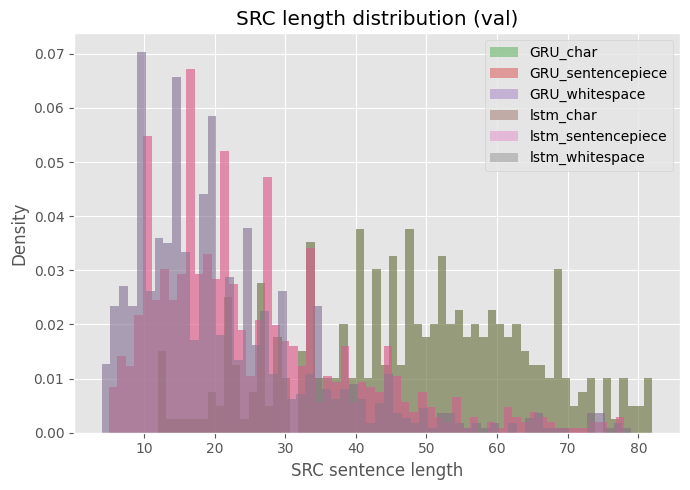

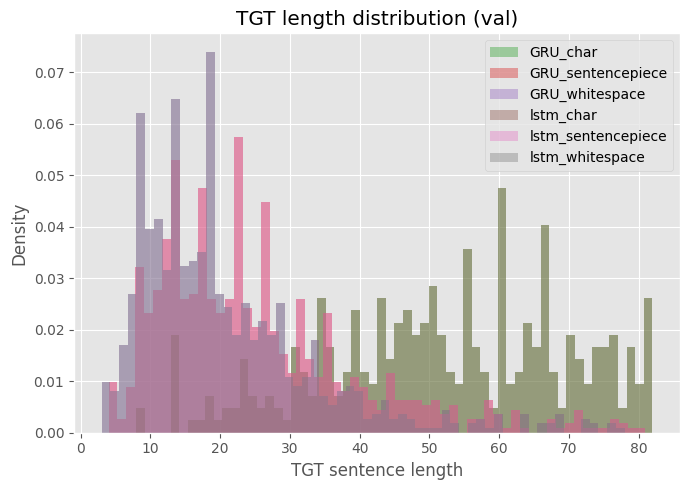

In [ ]:
def plot_length_hist_multi(all_stats, split="src", bins=50, title_suffix="(val)"):
    key = f"{split}_lengths"

    plt.figure(figsize=(7, 5))
    for (label, stats), color in zip(all_stats.items(), COLOR_CYCLE):
        lengths = stats[key]
        plt.hist(
            lengths,
            bins=bins,
            density=True,
            alpha=0.4,
            label=label,
            color=color,
        )

    plt.xlabel(f"{split.upper()} sentence length")
    plt.ylabel("Density")
    plt.title(f"{split.upper()} length distribution {title_suffix}")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_length_hist_multi(ALL_STATS_VAL, split="src", bins=60, title_suffix="(val)")
plot_length_hist_multi(ALL_STATS_VAL, split="tgt", bins=60, title_suffix="(val)")


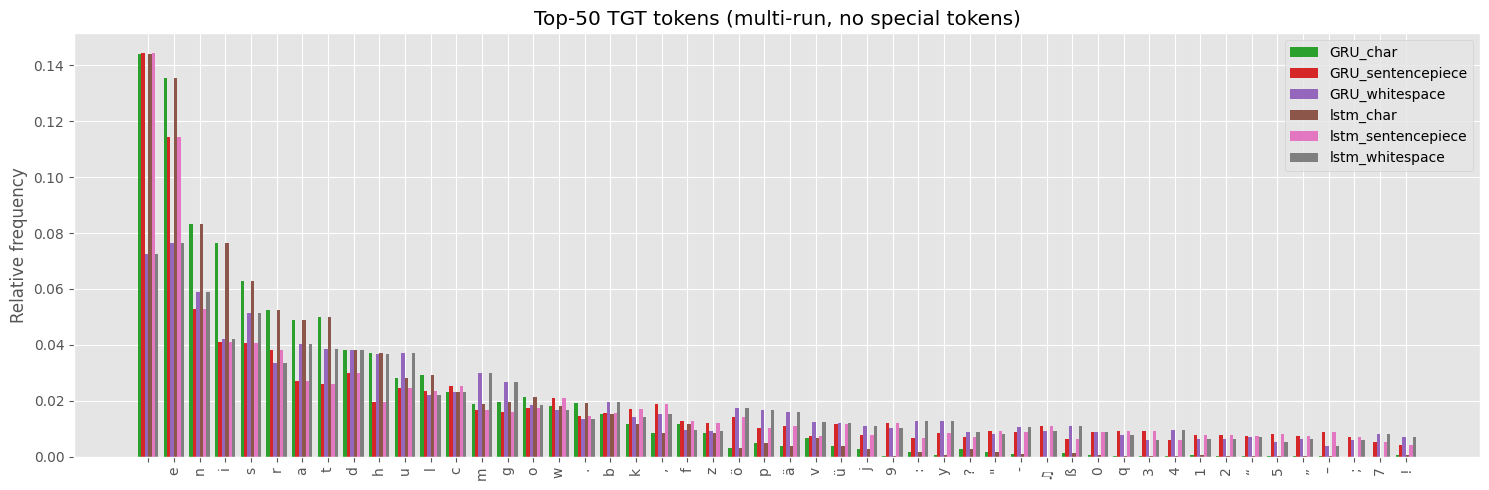

In [ ]:
def get_top_k_token_ids(all_stats, all_runs, k=30, target_side="tgt"):
    any_label = next(iter(all_runs.keys()))
    vocab = all_runs[any_label][f"{target_side}_vocab"]
    itos = vocab["itos"]
    
    special_tokens = {"<pad>", "<bos>", "<eos>", "<unk>"}

    joint_counter = Counter()
    key = f"{target_side}_counter"

    for stats in all_stats.values():
        joint_counter.update(stats[key])

    filtered_items = [
        (tid, freq) for tid, freq in joint_counter.items()
        if tid < len(itos) and itos[tid] not in special_tokens
    ]

    filtered_items.sort(key=lambda x: x[1], reverse=True)
    top_k = filtered_items[:k]

    token_ids = [tid for tid, _ in top_k]
    return token_ids


def plot_top_k_tokens_multi(all_runs, all_stats, k=30, target_side="tgt"):

    token_ids = get_top_k_token_ids(all_stats, all_runs, k=k, target_side=target_side)
    x = np.arange(len(token_ids))

    any_label = next(iter(all_runs.keys()))
    vocab = all_runs[any_label][f"{target_side}_vocab"]
    itos = vocab["itos"]

    token_strs = [itos[tid] if tid < len(itos) else f"<{tid}>" for tid in token_ids]

    plt.figure(figsize=(max(10, len(token_ids) * 0.3), 5))

    width = 0.8 / len(all_runs)
    for i, ((label, stats), color) in enumerate(zip(all_stats.items(), COLOR_CYCLE)):
        key = f"{target_side}_counter"
        counter = stats[key]
        freqs = [counter.get(tid, 0) for tid in token_ids]
        freqs = np.array(freqs, dtype=float)
        freqs = freqs / (freqs.sum() + 1e-12)

        plt.bar(
            x + i * width,
            freqs,
            width=width,
            label=label,
            color=color,
        )

    plt.xticks(x + width * (len(all_runs) - 1) / 2, token_strs, rotation=90)
    plt.ylabel("Relative frequency")
    plt.title(f"Top-{k} {target_side.upper()} tokens (multi-run, no special tokens)")
    plt.legend()
    plt.tight_layout()
    plt.show()


for label, run_info in ALL_RUNS.items():
    ALL_RUNS[label]["src_vocab"] = run_info["src_vocab"]
    ALL_RUNS[label]["tgt_vocab"] = run_info["tgt_vocab"]

plot_top_k_tokens_multi(ALL_RUNS, ALL_STATS_VAL, k=50, target_side="tgt")


[INFO] Found embedding at model.module.encoder.embedding


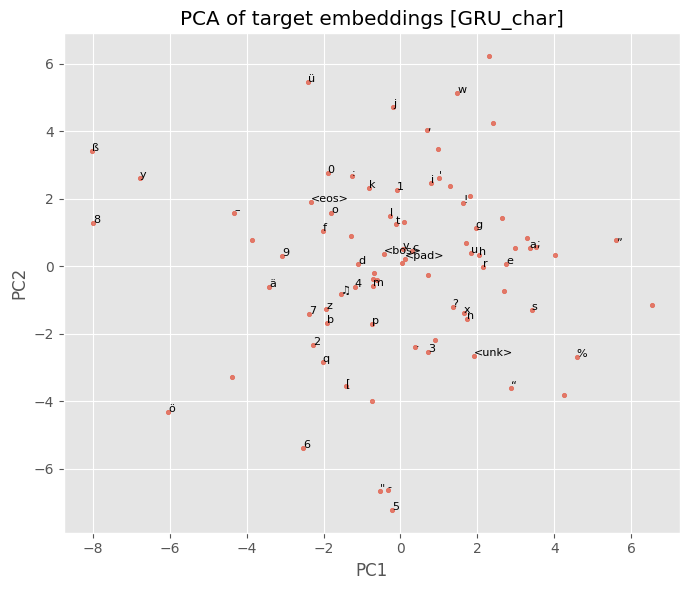


[GRU_char] Cluster 0:
e, s, r, a, h, —, ´, ó

[GRU_char] Cluster 1:
ß, y, –, 8

[GRU_char] Cluster 2:
u, g, !, ], …, ², ‟

[GRU_char] Cluster 3:
", 5

[GRU_char] Cluster 4:
w, ’, °

[GRU_char] Cluster 5:
<eos>, o, k, :

[GRU_char] Cluster 6:
<unk>, n, ., ?, x, ”

[GRU_char] Cluster 7:
6, $

[GRU_char] Cluster 8:
f, z, ä, 2, 4, 7, /

[GRU_char] Cluster 9:
“, %

[GRU_char] Cluster 10:
0, é

[GRU_char] Cluster 11:
 , i, l, ,, 1, «, ‘

[GRU_char] Cluster 12:
-, q, [, =

[GRU_char] Cluster 13:
<pad>, <bos>, t, d, c, v, &, »

[GRU_char] Cluster 14:
ö

[GRU_char] Cluster 15:
;, „

[GRU_char] Cluster 16:
m, b, p, ♫, 9, ½, á

[GRU_char] Cluster 17:
3

[GRU_char] Cluster 18:
 , β

[GRU_char] Cluster 19:
ü, j, ', ♪


In [ ]:
def get_tgt_embedding_matrix(model):

    if hasattr(model, "tgt_tok_embedding"):
        return model.tgt_tok_embedding.weight.detach().cpu()
    if hasattr(model, "tgt_embedding"):
        return model.tgt_embedding.weight.detach().cpu()
    if hasattr(model, "decoder"):
        dec = model.decoder
        if hasattr(dec, "embedding"): 
            return dec.embedding.weight.detach().cpu()
        if hasattr(dec, "embed"):     
            return dec.embed.weight.detach().cpu()
        if hasattr(dec, "embedding_layer"):
            return dec.embedding_layer.weight.detach().cpu()

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Embedding):
            print(f"[INFO] Found embedding at model.{name}")
            return module.weight.detach().cpu()

    raise ValueError("Could not locate target-side embedding in model.")


def plot_embedding_pca_single(run_label, run_info, max_tokens=500, annotate_top=50):
    if not SKLEARN_AVAILABLE:
        print("[WARN] sklearn not available, skip PCA.")
        return

    model = run_info["model"]
    tgt_vocab = run_info["tgt_vocab"]
    itos = tgt_vocab["itos"]

    emb = get_tgt_embedding_matrix(model)
    V = emb.shape[0]
    max_t = min(max_tokens, V)

    X = emb[:max_t].numpy()

    pca = PCA(n_components=3, random_state=0)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(7, 6))
    plt.scatter(X2[:, 0], X2[:, 1], s=10, alpha=0.7)
    plt.title(f"PCA of target embeddings [{run_label}]")

    for i in range(min(annotate_top, max_t)):
        token = itos[i]
        plt.text(
            X2[i, 0],
            X2[i, 1],
            token,
            fontsize=8,
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    if SKLEARN_AVAILABLE:
        n_clusters = 20
        km = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        labels = km.fit_predict(X2)

        clusters = {i: [] for i in range(n_clusters)}
        for idx, c in enumerate(labels):
            token = itos[idx] if idx < len(itos) else f"<{idx}>"
            clusters[c].append(token)

        for c in range(n_clusters):
            print(f"\n[{run_label}] Cluster {c}:")
            print(", ".join(clusters[c][:15]))

label_to_view = list(ALL_RUNS.keys())[0]
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=400, annotate_top=60)


[INFO] Found embedding at model.module.encoder.embedding


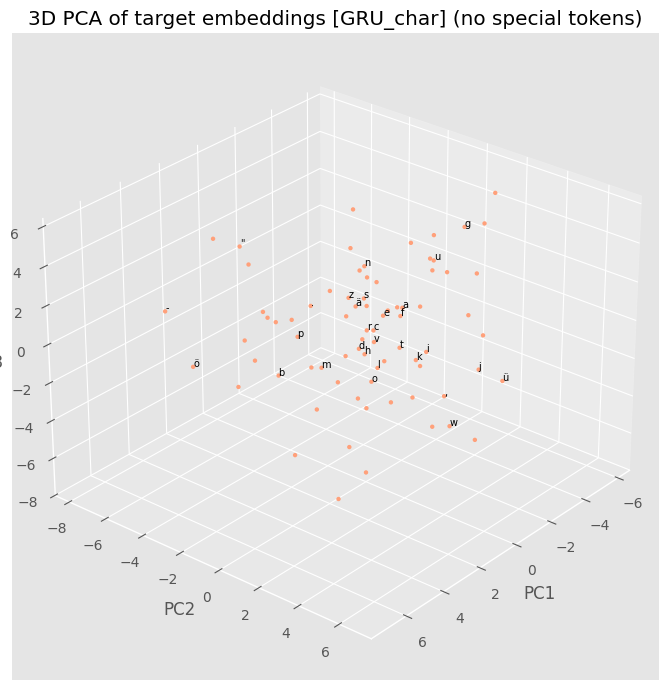


[GRU_char] Cluster 0:
b, ., p, q, [, =

[GRU_char] Cluster 1:
e, s, r, a, h, x, —, ”, ´, ó

[GRU_char] Cluster 2:
t, o, k, :

[GRU_char] Cluster 3:
ß, y, –, 8

[GRU_char] Cluster 4:
g, !, ;, …

[GRU_char] Cluster 5:
w, ’, °

[GRU_char] Cluster 6:
f, z, ?, 4, &

[GRU_char] Cluster 7:
d, l, c, m, v, ♫, », ½, á

[GRU_char] Cluster 8:
9, é

[GRU_char] Cluster 9:
", 5, 6

[GRU_char] Cluster 10:
i, ,, 1, «, ‘

[GRU_char] Cluster 11:
“, %

[GRU_char] Cluster 12:
ö, $

[GRU_char] Cluster 13:
β

[GRU_char] Cluster 14:
n, u, „, ], ², ‟

[GRU_char] Cluster 15:
ü, j, ', ♪

[GRU_char] Cluster 16:
ä, 2, 7, /

[GRU_char] Cluster 17:
-

[GRU_char] Cluster 18:
3

[GRU_char] Cluster 19:
0


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_embedding_pca_single(
    run_label,
    run_info,
    max_tokens=800,      
    plot_points=400,     
    annotate_top=50,     
    remove_subword_blank=True,  
    color = "red",
):
    if not SKLEARN_AVAILABLE:
        print("[WARN] sklearn not available, skip PCA.")
        return

    model = run_info["model"]
    tgt_vocab = run_info["tgt_vocab"]
    itos = tgt_vocab["itos"]

    special_tokens = {"<pad>", "<bos>", "<eos>", "<unk>"}

    emb = get_tgt_embedding_matrix(model)
    V = emb.shape[0]

    max_t = min(max_tokens, V)
    X_raw = emb[:max_t].numpy()
    tokens_raw = itos[:max_t]

    filtered_idx = []
    for i, tok in enumerate(tokens_raw):
        if tok in special_tokens:
            continue
        if remove_subword_blank and tok.strip() == "":
            continue
        filtered_idx.append(i)

    if len(filtered_idx) == 0:
        raise ValueError("No valid tokens left after filtering special tokens.")

    X = X_raw[filtered_idx]
    tokens = [tokens_raw[i] for i in filtered_idx]

    pca = PCA(n_components=3, random_state=0)
    X3 = pca.fit_transform(X)

    total_valid = len(tokens)
    plot_k = min(plot_points, total_valid)
    idx_plot = np.random.choice(total_valid, size=plot_k, replace=False)

    X3_plot = X3[idx_plot]
    tokens_plot = [tokens[i] for i in idx_plot]

    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        X3_plot[:, 0],
        X3_plot[:, 1],
        X3_plot[:, 2],
        s=10,
        alpha=1,
        color=color,
        edgecolor="none",
    )

    ax.set_title(f"3D PCA of target embeddings [{run_label}] (no special tokens)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    annot_k = min(annotate_top, len(tokens))
    for i in range(annot_k):
        ax.text(
            X3[i, 0],
            X3[i, 1],
            X3[i, 2],
            tokens[i],
            size=7,
        )


    ax.view_init(elev=28, azim=40)

    plt.tight_layout()
    plt.show()

    if SKLEARN_AVAILABLE:
        n_clusters = 20
        km = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
        labels = km.fit_predict(X3)

        clusters = {i: [] for i in range(n_clusters)}
        for idx, c in enumerate(labels):
            clusters[c].append(tokens[idx])

        for c in range(n_clusters):
            print(f"\n[{run_label}] Cluster {c}:")
            print(", ".join(clusters[c][:15]))



label_to_view = list(ALL_RUNS.keys())[0] 
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightsalmon")

[INFO] Found embedding at model.module.encoder.embedding


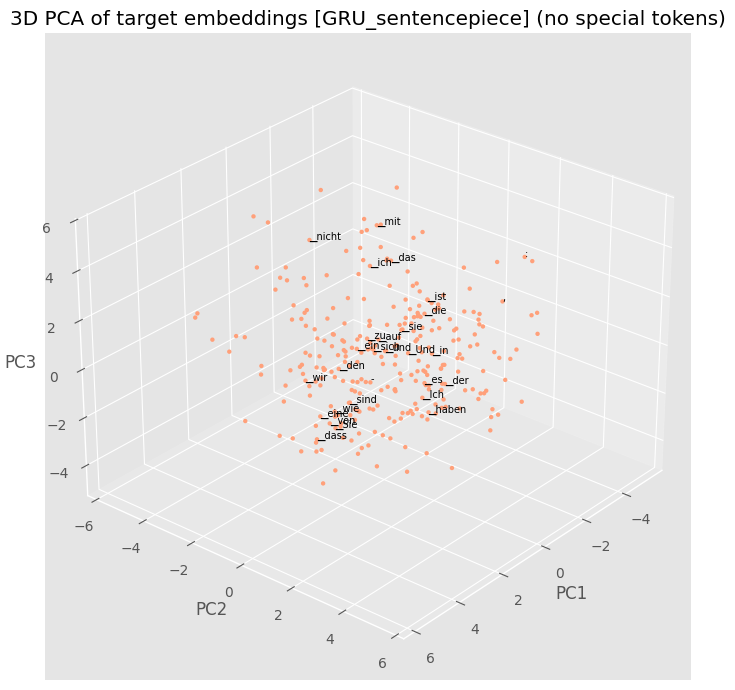


[GRU_sentencepiece] Cluster 0:
▁man, ▁einem, ▁–, ▁noch, ▁♫, ▁viel, ▁sagen, ▁zwei, ▁kommen, ▁Beispiel, ▁weiß, ▁Prozent, ▁warum, on

[GRU_sentencepiece] Cluster 1:
,, ▁", ▁hier, ▁des, ▁Aber, ▁sein, ▁Nun, ▁ihnen, de, ung, ▁glaube, ▁seine, ▁Problem, iert, ▁jeder

[GRU_sentencepiece] Cluster 2:
▁und, ▁auf, -, ▁wenn, ▁--, ▁aber, ▁also, ▁hatte, e, es, ▁Jahren, ▁wo, ▁selbst, ▁denn, ▁einige

[GRU_sentencepiece] Cluster 3:
▁der, ▁es, ▁Ich, ▁war, ▁was, ▁hat, ▁können, ▁habe, ▁Welt, ▁Ihnen, ▁Zeit, ▁dieses, ▁am, ▁mein, ▁denken

[GRU_sentencepiece] Cluster 4:
▁ein, ▁den, ▁sich, ▁wirklich, ▁Leute, ▁diesem, ▁diesen, ", ▁zur, ▁dort, ▁Kinder, ▁ganz, ▁nun, ▁denen, ▁sieht

[GRU_sentencepiece] Cluster 5:
▁Wir, ▁vor, ▁durch, ▁waren, ▁schon, ▁werde, ▁könnte, ▁heute, ▁Teil, in, ▁will, ▁zwischen, ▁B, ▁etwa

[GRU_sentencepiece] Cluster 6:
., ▁haben, ▁für, ▁so, ▁Es, ▁im, ▁einen, ▁etwas, .", ▁Er, ▁immer, ▁Leben, ▁müssen, ▁Der, ▁Ein

[GRU_sentencepiece] Cluster 7:
▁ich, ▁um, ▁mich, ▁dieser, ▁muss, !, ische, ern, ▁

In [ ]:
label_to_view = list(ALL_RUNS.keys())[1]  
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightsalmon")

[INFO] Found embedding at model.module.encoder.embedding


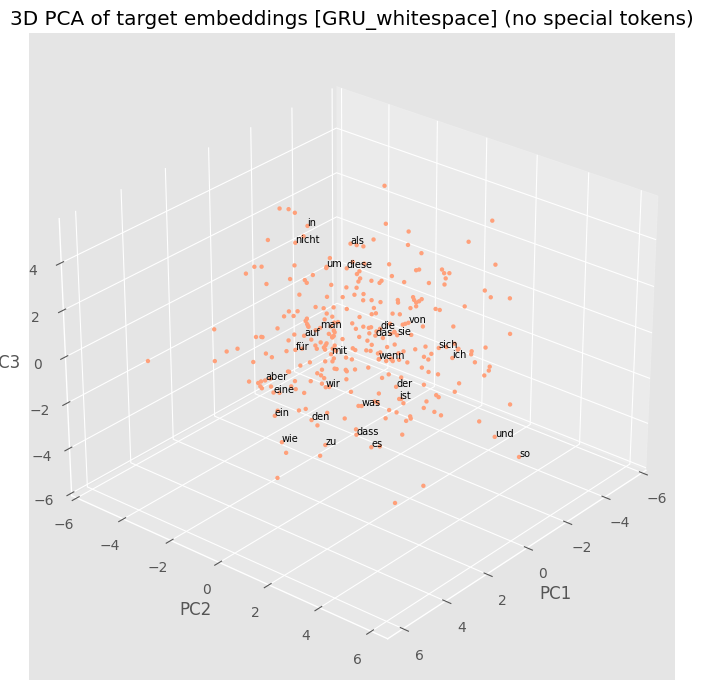


[GRU_whitespace] Cluster 0:
alle, sein, sind,, ob, sondern, ganze, machen., wissen,, weg, kleine, aus., gute

[GRU_whitespace] Cluster 1:
auf, man, für, also, sehr, mir, bis, zeit, nun, müssen, schon, war,, geht, sehen,, jeder

[GRU_whitespace] Cluster 2:
der, ist, hat, weil, ihr, jahre, würde, nicht,, also,, letzten, ersten, meisten, kommt, dollar, ihrem

[GRU_whitespace] Cluster 3:
als, um, im, werden, etwas, dieses, am, jetzt, viele, damit, einige, ziemlich, unser, einmal, an,

[GRU_whitespace] Cluster 4:
den, wie, unsere, leben, wissen, anderen, jahren, genau, tun, jahr, denen, natürlich, welche, arbeit, frage

[GRU_whitespace] Cluster 5:
sie, an, hier, einem, nach, mehr, du, sie,, waren, heute, meiner, während, ohne, sagen,, wird.

[GRU_whitespace] Cluster 6:
andere, sind., ganz, warum, davon, geschichte, sagen, dafür, bild, pro

[GRU_whitespace] Cluster 7:
einen, werden., neue, darüber, hatten, sagte, glaube,, keinen

[GRU_whitespace] Cluster 8:
mit, er, haben, des, dieser, ist.

In [ ]:
label_to_view = list(ALL_RUNS.keys())[2] 
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightsalmon")

[INFO] Found embedding at model.module.encoder.embedding


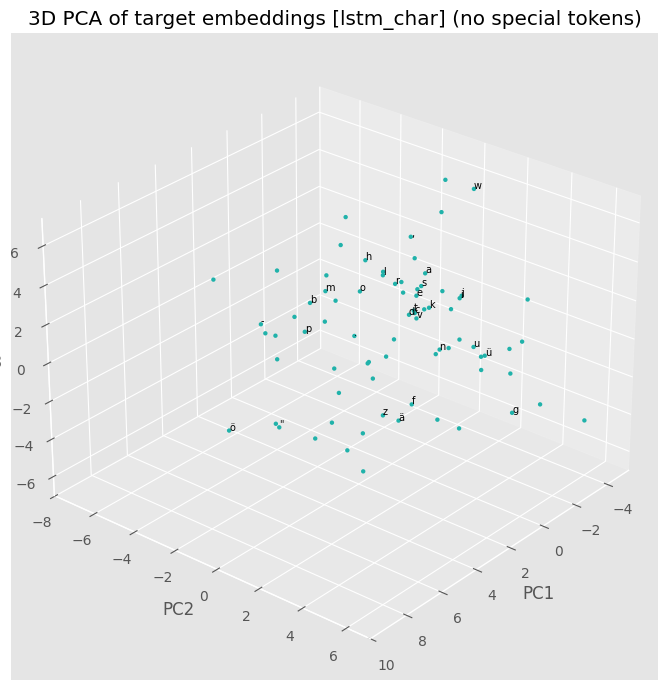


[lstm_char] Cluster 0:
n, u, ', „, ], β, ², ‟

[lstm_char] Cluster 1:
m, b, q, ½, =

[lstm_char] Cluster 2:
2, 6, 7, $

[lstm_char] Cluster 3:
v, x, &, »

[lstm_char] Cluster 4:
y, –, 8

[lstm_char] Cluster 5:
h, ,, 0, «

[lstm_char] Cluster 6:
e, s, r, a, —, ´, ó

[lstm_char] Cluster 7:
“, %

[lstm_char] Cluster 8:
f, z, ä, 4, /

[lstm_char] Cluster 9:
t, k, j, :, 1

[lstm_char] Cluster 10:
♫, 9, é

[lstm_char] Cluster 11:
g, ;, …

[lstm_char] Cluster 12:
-, 3

[lstm_char] Cluster 13:
ö

[lstm_char] Cluster 14:
ß

[lstm_char] Cluster 15:
", 5

[lstm_char] Cluster 16:
w, ’, °

[lstm_char] Cluster 17:
., p, ?, [, ”

[lstm_char] Cluster 18:
i, d, l, c, o, á, ‘

[lstm_char] Cluster 19:
ü, !, ♪


In [ ]:
label_to_view = list(ALL_RUNS.keys())[3] 
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightseagreen")

[INFO] Found embedding at model.module.encoder.embedding


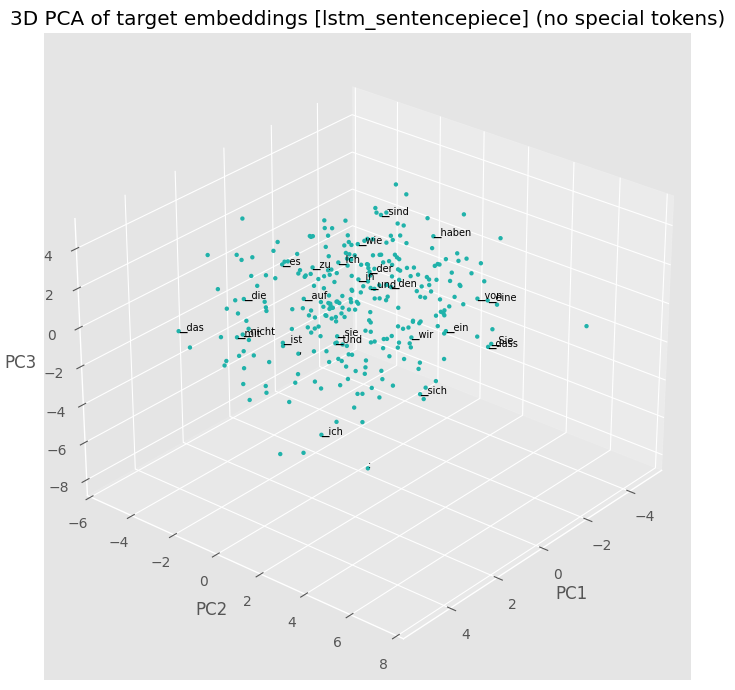


[lstm_sentencepiece] Cluster 0:
▁wir, ▁Und, ▁sich, ▁Es, ▁diese, ▁einem, ▁dann, ▁also, ▁mir, ▁wirklich, ▁Also, ▁tun, ▁diesen, en, ▁ganz

[lstm_sentencepiece] Cluster 1:
▁die, ▁es, ▁werden, ▁oder, ▁hier, ▁auch, ▁machen, ▁Jahren, ▁jetzt, ▁dies, ▁gut, ▁Wie, ▁drei, ▁hatten, ;

[lstm_sentencepiece] Cluster 2:
▁der, ▁haben, ▁so, ▁aus, ▁Menschen, ▁etwas, ▁Welt, .", ▁Er, ▁immer, ▁meine, ▁Zeit, ▁unsere, ▁ihre, ▁Der

[lstm_sentencepiece] Cluster 3:
▁", ▁Aber, ung, ▁glaube, iert, ▁Arbeit

[lstm_sentencepiece] Cluster 4:
▁Sie, ▁von, ▁dass, ▁eine, ▁an, st, d, ▁würden

[lstm_sentencepiece] Cluster 5:
▁in, ▁zu, ▁Ich, ▁was, ▁hat, ▁können, s, ▁habe, ▁Wenn, ▁Ihnen, ▁am, ▁hatte, es, ▁alles, ▁wo

[lstm_sentencepiece] Cluster 6:
▁auf, ▁man, ▁einer, ▁wurde, ▁weil, ▁einfach, ▁viele, ▁möchte, ▁konnte, on, ▁Geld

[lstm_sentencepiece] Cluster 7:
▁des, ▁Die, ▁nur, er, ▁wieder, ischen, ▁vom, ▁Problem, ▁dafür, '

[lstm_sentencepiece] Cluster 8:
▁uns, ▁wird, ▁sehen, ▁vor, ▁mehr, ▁diesem, ▁Art, ▁andere, ▁In, ▁du, ▁z

In [ ]:
label_to_view = list(ALL_RUNS.keys())[4] 
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightseagreen")

[INFO] Found embedding at model.module.encoder.embedding


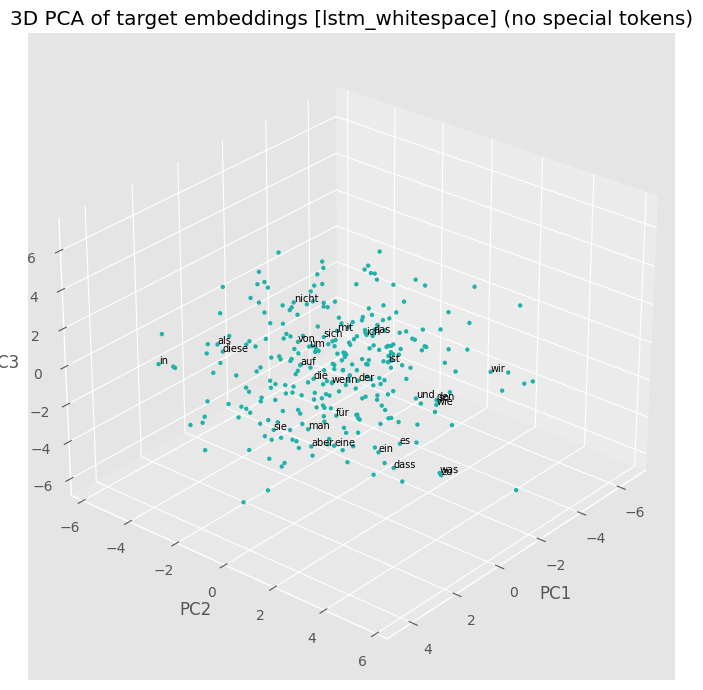


[lstm_whitespace] Cluster 0:
sehr, habe, bei, da, wieder, paar, drei, sondern, unter, doch, machen., wissen,, kann,, lassen, seit

[lstm_whitespace] Cluster 1:
die, der, von, sich, wenn, sind, einer, ihnen, mich, können, ihre, mein, dinge, haben., jahre

[lstm_whitespace] Cluster 2:
man, für, dem, gibt, art, vielleicht, nun, all, müssen, schon, sehen,, kein, vom, können,, zwischen

[lstm_whitespace] Cluster 3:
den, wie, auch, ihr, leute, würde, ersten, könnte, kleinen, will, ins, dollar

[lstm_whitespace] Cluster 4:
das, ich, ist, haben, uns, ♫, meine, wurde, zur, nicht,, ihren, vielen, hat,, millionen, hat.

[lstm_whitespace] Cluster 5:
auf, um, im, des, dieser, andere, damit, einige, teil, gerade, unser, einmal, wäre, beispiel, dafür

[lstm_whitespace] Cluster 6:
es, ein, eine, an, oder, nur, menschen, mehr, du, leben, sie,, etwa, sagen,, kommt, arbeit

[lstm_whitespace] Cluster 7:
und, so, war, –, hat, noch, wird, weil, wirklich, dies, vor, diesem, ihn, gut, sein.

[lstm_whitespace

In [ ]:
label_to_view = list(ALL_RUNS.keys())[5] 
plot_embedding_pca_single(label_to_view, ALL_RUNS[label_to_view], max_tokens=300, annotate_top=30, color = "lightseagreen")